# ICESpark Ice Sat 2 Orbit Crossing SODA sites

In [1]:
import os

import geopandas as gpd
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col

from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils.adapter import Adapter

In [2]:
spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages',
           'org.apache.sedona:sedona-python-adapter-3.0_2.12:1.2.0-incubating,org.datasyslab:geotools-wrapper:1.1.0-25.2'). \
    getOrCreate()

22/04/20 15:17:06 WARN Utils: Your hostname, jia-imac.local resolves to a loopback address: 127.0.0.1; using 10.71.12.51 instead (on interface en0)
22/04/20 15:17:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/jiayu/.ivy2/cache
The jars for the packages stored in: /Users/jiayu/.ivy2/jars
org.apache.sedona#sedona-python-adapter-3.0_2.12 added as a dependency
org.datasyslab#geotools-wrapper added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8582af09-269d-4883-9639-7a9b0bbe4af4;1.0
	confs: [default]
	found org.apache.sedona#sedona-python-adapter-3.0_2.12;1.2.0-incubating in central
	found org.locationtech.jts#jts-core;1.18.0 in local-m2-cache
	found org.wololo#jts2geojson;0.16.1 in local-m2-cache
	found com.fasterxml.jackson.core#jackson-databind;2.12.2 in local-m2-cache
	found com.fasterxml.jackson.core#jackson-annotations;2.12.2 in local-m2-cache
	found com.fasterxml.jackson.core#jackson-core;2.12.2 in local-m2-cache
	found org.apache.sedona#sedona-core-3.0_2.12;1.2.0-incubating in local-m2-cache
	found org.scala-lang.modules#scala-collection-compat_2.12;2.5.0 in local-m2-cache
	found org.apache.sedona#sedona-sql-3.0_2.12;1

In [3]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")

## Load ICE_SAT2 orbits (size 2.6GB, 13704 orbits) into Spark
Files are originally in KML. They are converted to a single WKT file using GDAL ogr2ogr command.

Filename example: IS2_RGT_0702_cycle3_14-May-2019.kml.csv

In [4]:
ice2_df = spark.read.format("csv").\
    option("delimiter", ",").\
    option("header", "true").\
    load("data/IS2_RGTs_aggr_data_timestamp-head1000.csv").repartition(10)

ice2_df.createOrReplaceTempView("is2_df_raw")

ice2_df.show(2)

print(ice2_df.count())


+--------------------+-----+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
|                 WKT| Name|description|timestamp|begin| end| altitudeMode|tessellate|extrude|visibility|drawOrder|icon|            filename|
+--------------------+-----+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
|LINESTRING (-47.2...|RGT 3|       null|     null| null|null|clampToGround|        -1|      0|         1|     null|null|IS2_RGT_0003_cycl...|
|LINESTRING (-23.7...|RGT 2|       null|     null| null|null|clampToGround|        -1|      0|         1|     null|null|IS2_RGT_0002_cycl...|
+--------------------+-----+-----------+---------+-----+----+-------------+----------+-------+----------+---------+----+--------------------+
only showing top 2 rows

999


## Create Apache Sedona DataFrame

In [5]:
ice2_df = spark.sql("select ST_FlipCoordinates(ST_GeomFromWKT(WKT)) as orbit, Name, altitudeMode, tessellate, extrude, visibility, filename from is2_df_raw").cache()
ice2_df.createOrReplaceTempView("is2_df")
ice2_df.show(2)
ice2_df.select("filename").show(2, truncate = False)
print(ice2_df.count())

+--------------------+-----+-------------+----------+-------+----------+--------------------+
|               orbit| Name| altitudeMode|tessellate|extrude|visibility|            filename|
+--------------------+-----+-------------+----------+-------+----------+--------------------+
|LINESTRING (0.052...|RGT 3|clampToGround|        -1|      0|         1|IS2_RGT_0003_cycl...|
|LINESTRING (0.031...|RGT 4|clampToGround|        -1|      0|         1|IS2_RGT_0004_cycl...|
+--------------------+-----+-------------+----------+-------+----------+--------------------+
only showing top 2 rows

+---------------------------------------+
|filename                               |
+---------------------------------------+
|IS2_RGT_0003_cycle2_28-Dec-2018.kml.csv|
|IS2_RGT_0004_cycle8_25-Jun-2020.kml.csv|
+---------------------------------------+
only showing top 2 rows



999


## Operations

Three points

SODA-A: (73.00043, -148.33627)

SODA-B: (75.46388, -145.63685)

SODA-C: (77.73677, -139.14153)

### Method 1: Distance between Orbit and SODA < 50KM using ST_Distance

#### IceSat2 data needs to be converted from WGS84 (epsg:4326) CRS to meter-based epsg:4087 (WGS 84 / World Equidistant Cylindrical) using Sedona's ST_Transform

In [6]:
# modified projection

result_df1 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Distance(ST_Transform(ST_POINT (73.00043,-148.33627), \'epsg:4326\',\'epsg:4087\'), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\')) < 50000')
result_df1.show(2)
print('SODA-A number of crosses: ', result_df1.count())
result_df2 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Distance(ST_Transform(ST_POINT (75.46388,-145.63685), \'epsg:4326\',\'epsg:4087\'), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\')) < 50000')
print('SODA-B number of crosses: ', result_df2.count())

result_df3 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Distance(ST_Transform(ST_POINT (77.73677, -139.14153), \'epsg:4326\',\'epsg:4087\'), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\')) < 50000')
print('SODA-C number of crosses: ', result_df3.count())

+--------------------+------+-------------+----------+-------+----------+--------------------+
|               orbit|  Name| altitudeMode|tessellate|extrude|visibility|            filename|
+--------------------+------+-------------+----------+-------+----------+--------------------+
|LINESTRING (0.005...|RGT 83|clampToGround|        -1|      0|         1|IS2_RGT_0083_cycl...|
|LINESTRING (0.005...|    83|clampToGround|        -1|      0|         1|IS2_RGT_0083_02-J...|
+--------------------+------+-------------+----------+-------+----------+--------------------+
only showing top 2 rows

SODA-A number of crosses:  10
SODA-B number of crosses:  10
SODA-C number of crosses:  20


### Method 2: Orbit within a 50KM circle of SODA, using ST_Buffer
#### IceSat2 data needs to be converted from WGS84 (epsg:4326) CRS to meter-based epsg:4087 (WGS 84 / World Equidistant Cylindrical) using Sedona's ST_Transform

In [18]:
result_df1 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(ST_Buffer(ST_Transform(ST_POINT (73.00043,-148.33627), \'epsg:4326\',\'epsg:4087\'), 50000), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\'))')
result_df1.show(2)
print('SODA-A crosses: ', result_df1.count())

result_df2 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(ST_Buffer(ST_Transform(ST_POINT (75.46388,-145.63685), \'epsg:4326\',\'epsg:4087\'), 50000), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\'))')
print('SODA-B crosses: ', result_df2.count())

result_df3 = spark.sql('SELECT * '
                     'FROM is2_df '
                     'WHERE ST_Intersects(ST_Buffer(ST_Transform(ST_POINT (77.73677, -139.14153), \'epsg:4326\',\'epsg:4087\'), 50000), ST_Transform(orbit, \'epsg:4326\',\'epsg:4087\'))')
print('SODA-C crosses: ', result_df3.count())


+-----+----+------------+----------+-------+----------+--------+
|orbit|Name|altitudeMode|tessellate|extrude|visibility|filename|
+-----+----+------------+----------+-------+----------+--------+
+-----+----+------------+----------+-------+----------+--------+

SODA-A crosses:  0
SODA-B crosses:  0
SODA-C crosses:  0


### Find orbits in Year 2019 in the SODA-C result

In [16]:
result_df3.createOrReplaceTempView("is2_df")
result_df3 = spark.sql('SELECT * '
                       'FROM is2_df '
                       'WHERE filename LIKE \'%May-2017%\'')
result_df3_sorted = result_df3.sort(col('filename').asc())
result_df3_sorted.select('filename').show(truncate = False)
#result_df1_sorted.select('filename').show(result_df1.count(), truncate = False)

+--------+
|filename|
+--------+
+--------+



## Visualize the query result using GeoPandas

### Read a country shapefile as the base map using Sedona

In [10]:
countries = ShapefileReader.readToGeometryRDD(sc, "data/ne_50m_admin_0_countries_lakes")
countries_df = Adapter.toDf(countries, spark).select("geometry", "NAME_EN")
countries_df.show(2)

22/04/20 15:18:15 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+
|            geometry|             NAME_EN|
+--------------------+--------------------+
|MULTIPOLYGON (((3...|Zimbabwe         ...|
|MULTIPOLYGON (((3...|Zambia           ...|
+--------------------+--------------------+
only showing top 2 rows



### Put SODA-C into a Sedona DF and convert it to 50KM circle

In [11]:
soda_list = ["POINT (73.00043 -148.33627)", "POINT (75.46388 -145.63685)", "POINT (77.73677 -139.14153)"]
# soda_list = ["POINT (77.73677 -139.14153)"]
soda_df = spark.createDataFrame(soda_list,StringType())
# Convert to epsg:4087 meter-based CRS
soda_df = soda_df.selectExpr('ST_Transform(ST_GeomFromWKT(value), \'epsg:4326\',\'epsg:3413\') as is2_df')
soda_df.show()
# Create circles using 50KM
soda_df = soda_df.selectExpr('ST_Buffer(is2_df, 50000) as is2_df')
# Convert to epsg:4326 WGS84
soda_df = soda_df.selectExpr('ST_FlipCoordinates(ST_Transform(is2_df, \'epsg:3413\',\'epsg:4326\')) as is2_df')
# soda_df.show()

+--------------------+
|              is2_df|
+--------------------+
|POINT (-1804587.9...|
|POINT (-1555620.5...|
|POINT (-1329850.8...|
+--------------------+



### Convert Sedona DataFrame to GeoPandas DataFrame

In [12]:
country_gpd = gpd.GeoDataFrame(countries_df.toPandas(), geometry="geometry")
soda_gpd = gpd.GeoDataFrame(soda_df.toPandas(), geometry="is2_df")
orbit_gpd = gpd.GeoDataFrame(result_df3.selectExpr('ST_FlipCoordinates(orbit) as orbit').toPandas(), geometry="orbit")

/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/array.py:85: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  aout[:] = out


### Plot the maps

/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/geopandas/plotting.py:38: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/lib/python3.8/site-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
/Users/jiayu/.local/share/virtualenvs/gallery-icespark-yOC315wH/li

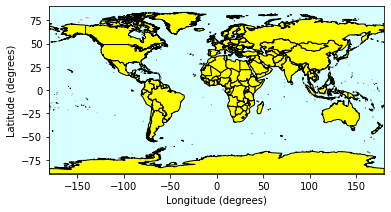

In [15]:
base = country_gpd.plot(color='yellow', edgecolor='black', zorder=1)
base.set_facecolor('#d7fffe')
# SODA-A Close-up view
#base.set_xlim(-151, -146)
#base.set_ylim(71, 75)
# SODA-B Close-up view
#base.set_xlim(-147.5, -143.5)
#base.set_ylim(74, 77)
# SODA-C Close-up view
# base.set_xlim(-145, -135)
# base.set_ylim(75, 80)
# SODA-ABC Close-up view
# base.set_xlim(-160, -130)
# base.set_ylim(60, 90)
# Global view
base.set_xlim(-180, 180)
base.set_ylim(-90, 90)
base.set_xlabel('Longitude (degrees)')
base.set_ylabel('Latitude (degrees)')
orbit = orbit_gpd.plot(ax=base, color='#06470c', zorder=3)
soda = soda_gpd.plot(ax=orbit, color='red', alpha=0.6, zorder=2)